# Gibbs Sampling 
Gibbs Sampling updates each component of the state by sampling from its conditional distribution given other components
This method can eliminate or reduce the need for "tuning" of a proposal distribution.

Gibbs sampling is a MCMC algorithm that repeatedly samples from the conditional distribution of one variable of the target distribution p, given all other variables. It assumes we can compute conditional distributions of one variable conditioned on all of other variables and sample exactly from these distributions.

## Gibbs Sampling for Bayesian Linear Regression


In [212]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
plt.rcParams['figure.figsize'] = (10, 5)

# Steps to derive a Gibbs Sampler
1. Write down posterior conditional density
2. Eliminate variables that do not depend on the current sampling variable
3. Assume that density of interest variable and all other variable are fixed. 
4. Find the distribution of posterior conditional density

## Step 1 : Calculate $\beta_0$ and  $\beta_1$

In [213]:
def sample_beta_0(y, x, beta_1, tau, mu_0, tau_0):
    precision = tau_0 + tau * len(y)
    mean = tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)
    mean /= precision
    
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [214]:
def sample_beta_1(y, x, beta_0, tau, mu_1, tau_1):
    precision = tau_1 + tau * np.sum(x * x)
    mean = tau_1 * mu_1 + tau * np.sum( (y - beta_0) * x)
    mean /= precision
    
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [215]:
def sample_tau(y, x, beta_0, beta_1, alpha, beta):
    alpha_new = alpha + len(y) / 2
    resid = y - beta_0 - beta_1 * x
    beta_new = beta + np.sum(resid * resid) / 2
    
    return np.random.gamma(alpha_new, 1 / beta_new)

## Step 2: Sample Synthetic Data

Text(0, 0.5, 'y')

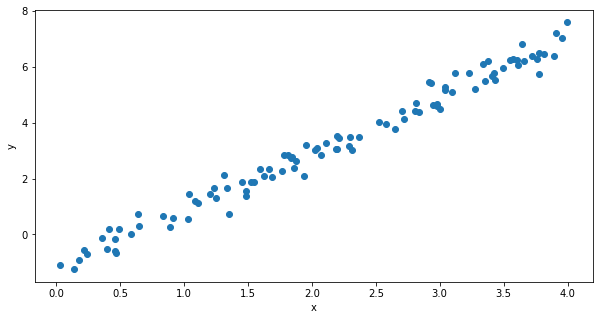

In [216]:
beta_0_true = -1
beta_1_true = 2
tau_true = 10

N = 100
x = np.random.uniform(low = 0, high = 4, size = N)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))


synth_plot = plt.plot(x, y, "o")
plt.xlabel("x")
plt.ylabel("y")

## Step 3: Write Gibbs Sampler

In [217]:
## specify initial values
init = {"beta_0": 0,
        "beta_1": 0,
        "tau": 2}

## specify hyper parameters
hypers = {"mu_0": 0,
         "tau_0": 1,
         "mu_1": 0,
         "tau_1": 1,
         "alpha": 2,
         "beta": 1}

In [218]:
def gibbs(y, x, iters, init, hypers):
    
    beta_0 = init["beta_0"]
    beta_1 = init["beta_1"]
    tau = init["tau"]
    
    trace = np.zeros((iters, 3)) ## trace to store values of beta_0, beta_1, tau
    
    for it in range(iters):
        beta_0 = sample_beta_0(y, x, beta_1, tau, hypers["mu_0"], hypers["tau_0"])
        beta_1 = sample_beta_1(y, x, beta_0, tau, hypers["mu_1"], hypers["tau_1"])
        tau = sample_tau(y, x, beta_0, beta_1, hypers["alpha"], hypers["beta"])
        trace[it,:] = np.array((beta_0, beta_1, tau))
        
    trace = pd.DataFrame(trace)
    trace.columns = ['beta_0', 'beta_1', 'tau']
        
    return trace


## Plotting Data

In [219]:
iters = 10000
trace = gibbs(y, x, iters, init, hypers)
tau_sample = gibbs(y, x, iters, init, hypers)["tau"]
beta_0_sample = gibbs(y, x, iters, init, hypers)["beta_0"]
beta_1_sample = gibbs(y, x, iters, init, hypers)["beta_1"]

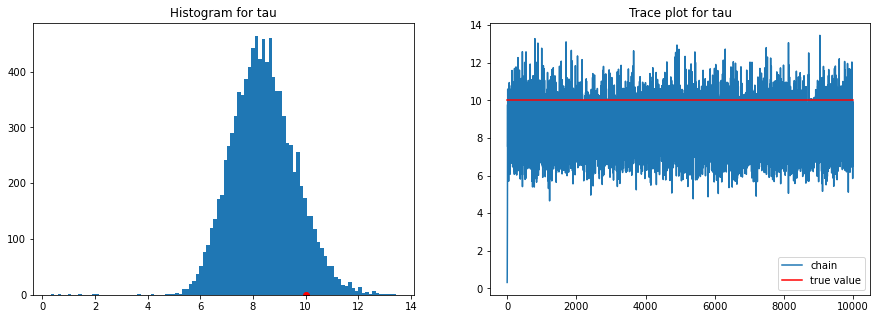

In [220]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(tau_sample, bins=100)
plt.scatter(tau_true, 0, c="r")
plt.title("Histogram for tau")
plt.subplot(1,2,2)
plt.plot(tau_sample, label="chain")
plt.plot([0, len(tau_sample)], [tau_true, tau_true], c="r", label="true value")
plt.title("Trace plot for tau")
plt.legend()
plt.show()

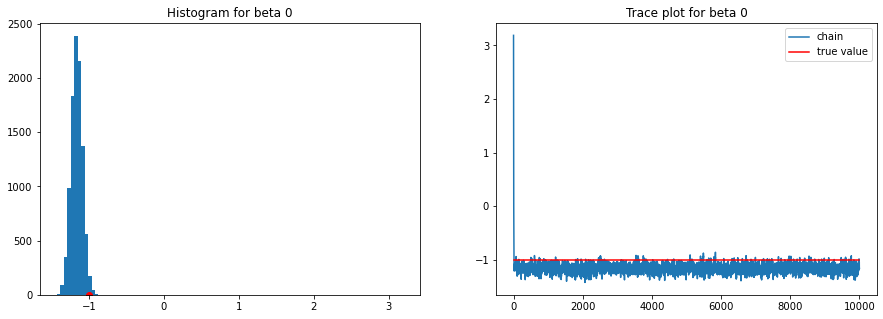

In [221]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(beta_0_sample, bins=100)
plt.scatter(beta_0_true, 0, c="r")
plt.title("Histogram for beta 0")
plt.subplot(1,2,2)
plt.plot(beta_0_sample, label="chain")
plt.plot([0, len(beta_0_sample)], [beta_0_true, beta_0_true], c="r", label="true value")
plt.title("Trace plot for beta 0")
plt.legend()
plt.show()

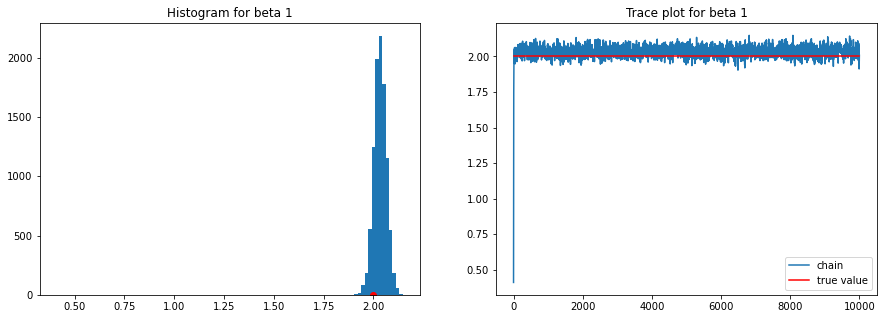

In [222]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(beta_1_sample, bins=100)
plt.scatter(beta_1_true, 0, c="r")
plt.title("Histogram for beta 1")
plt.subplot(1,2,2)
plt.plot(beta_1_sample, label="chain")
plt.plot([0, len(beta_1_sample)], [beta_1_true, beta_1_true], c="r", label="true value")
plt.title("Trace plot for beta 1")
plt.legend()
plt.show()

Text(0, 0.5, 'Parameter value')

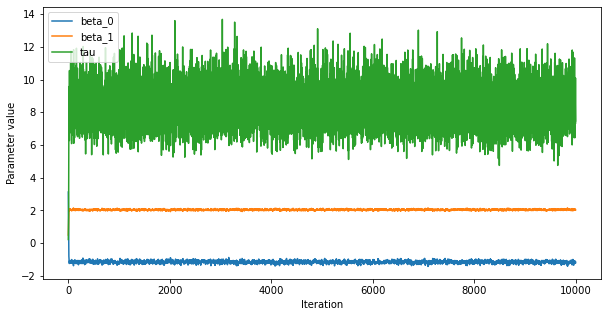

In [223]:
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

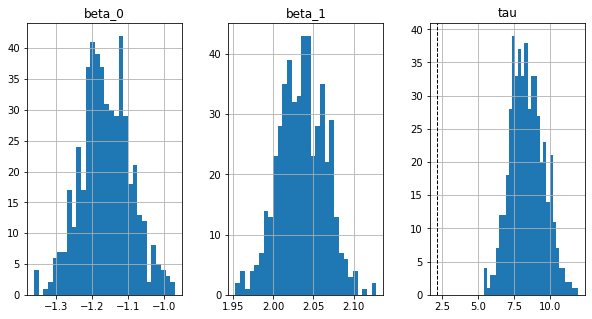

In [224]:
trace_burnt = trace[500:999]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)

In [225]:
print(trace_burnt.median())
print(trace_burnt.mean())
print(trace_burnt.std())

beta_0   -1.165968
beta_1    2.036011
tau       8.369527
dtype: float64
beta_0   -1.162645
beta_1    2.035754
tau       8.421151
dtype: float64
beta_0    0.069450
beta_1    0.029118
tau       1.158526
dtype: float64


## Gibbs Sampling for Multivarative Linear Regression


### Step 1 : Simulate Data
- Sample data from model 
- Construct the matrix X, vector y and theta

In [226]:
def simulate_data(w, b, sigma, N, design_range = (-10,10)):
        designs = np.random.uniform(design_range[0], design_range[1], size=(N, w.size))
        theta = np.expand_dims(np.concatenate([w, [b]], axis=0), axis=1)
        X = np.concatenate([designs, np.ones((N, 1))], axis=1)
        y_mean = (X @ theta).squeeze()
        y = np.random.multivariate_normal(mean=y_mean, cov=np.diag([sigma**2] * N))
        
        return X,y
        
        
def plot_data(w, b, X, design_range = (-10,10)):
        # Plot data
        X,y = simulate_data(w, b, sigma = 1.5, N = 1000, design_range = (-10,10))
        x = X[:, 0]
        plt.scatter(x, y, label="data")
        x_dense = np.linspace(design_range[0], design_range[1], 100)
        y_dense = x_dense * w[0] + b
        plt.plot(x_dense, y_dense, label="y mean")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.title("Simulated data, N="+str(N))
        plt.show()


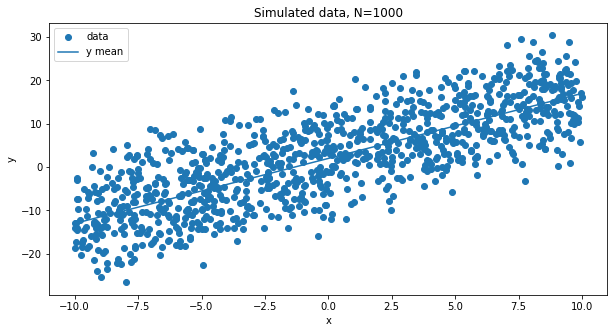

In [227]:
# True weight(s)
w = np.array([1.5, -1.0, 0.7])

# Input dimensionality
d = w.size

# True intercept
b = 2.0

# True standard deviation
sigma = 1.5

# Number of data points
N = 1000


X,y = simulate_data(w, b, sigma, N, design_range = (-10,10))
plot_data(w, b, X, design_range = (-10,10))

### Step 2 : Define priors

In [228]:
# Define priors
alpha_0 = 0.0001
beta_0 = 0.0001
sigma_0 = np.identity(d+1) * 1000 # Should be a matrix which as sigma in diag
theta_0 = np.zeros(shape=(d+1,))

## Step 3: Initialize chain
- Initialize precision gamma and parameter theta
- Draw sample from the posteriors

In [229]:
gamma = 1
# Define theta as a vector with zeros
theta = np.zeros(d+1)

M = 5

# Number of samples per chain
SPC = 1000

# Total number of parameters in the model
P = d + 2

# Initialize samples array
samples = np.zeros((N,P))

### Uniform Distribution

In [230]:
# Draw T samples from the posterior
T = 200
#designs = np.random.uniform(-10, 10, size=(N, w.size))

def draw_samples(SPC, theta, X, y, beta_0, alpha_0):
    for i in range(SPC):
        # Compute the parameters for gamma distribution from which we sample tau
        alpha = alpha_0 + N/2

        z = y - X @  theta

        beta = beta_0 + 0.5 * z.T @ z

        # Sample tau
        tau_samples = np.random.gamma(alpha, 1/beta)


        # Compute the parameters for the normal distribution from which we sample theta
        A = tau_samples * X.T @ X 
        b = tau_samples * X.T @ y
        mu = np.linalg.solve(A, b)
        Sigma = np.linalg.inv(A)

        # Sample theta
        #print(mu.shape, Sigma.shape)
        theta = np.random.multivariate_normal(mu, Sigma)


        # Store within chain samples
        samples[i, 0] = tau_samples
        samples[i, 1:] = theta
    return samples

samples = draw_samples(SPC, theta, X, y, beta_0, alpha_0)

In [231]:
samples

array([[ 0.00776643,  1.48507908, -0.9492486 ,  0.70779403,  2.27602659],
       [ 0.45913164,  1.50896083, -0.99275053,  0.68454542,  2.02096691],
       [ 0.51742308,  1.51743655, -0.9960906 ,  0.69980395,  2.1040412 ],
       ...,
       [ 0.49685995,  1.51590865, -1.0047811 ,  0.68440592,  2.04396473],
       [ 0.52113876,  1.50789421, -0.98556788,  0.70075933,  2.04413429],
       [ 0.49360523,  1.49530804, -1.00157864,  0.67152527,  2.09495905]])

### Gaussian Distribution

In [232]:
def draw_gauss_samples(SPC, theta, X, y, beta_0, alpha_0, theta_0):
    for i in range(SPC):
        # Compute the parameters for gamma distribution from which we sample tau
        alpha = alpha_0 + N/2

        z = y - X @  theta

        beta = beta_0 + 0.5 * z.T @ z

        # Sample tau
        tau_samples = np.random.gamma(alpha, 1/beta)
        sigma2 = 1/tau_samples

        # Compute the parameters for the normal distribution from which we sample theta
        A = (X.T @ X)/ sigma2 + np.linalg.inv(sigma_0)
        b = (X.T @y)/sigma2 + np.linalg.inv(sigma_0) @ theta_0
        
        # mu = np.linalg.inv(A) * beta
        mu = np.linalg.solve(A, b)
        Sigma = np.linalg.inv(A)

        # Sample theta
        # print(mu.shape,Sigma.shape)
        theta = np.random.multivariate_normal(mu, Sigma)


        # Store within chain samples
        samples[i, 0] = tau_samples
        samples[i, 1:] = theta
    return samples

gauss_samples = draw_gauss_samples(SPC, theta, X, y, beta_0, alpha_0, theta_0)

## Step 4: Analayze the chain


In [233]:
chain_samples = np.zeros((M, N, P))

# Run M chains for PSRF calculation
for m in range(M):

    # Initialize chain stochastically
    theta = np.zeros(d + 1) + np.random.normal(loc=0, scale=0.5, size=(d + 1))
    tau = 1.0 + np.random.normal(loc=0, scale=0.2)

    # Run chain
    multi_samples = draw_gauss_samples(SPC, theta, X, y, beta_0, alpha_0, theta_0)
    
    # Store within chain samples
    chain_samples[m, :, :] = multi_samples


In [234]:
def compute_psrf(samples):
    
    """
    param samples: 3 dimensional numpy array of shape (M, N, P)
    returns: R-hat values for each model parameter
    """
    M, N, P = samples.shape
    
    within_chain_means = samples.mean(axis=1)
    within_chain_vars = samples.var(axis=1)
    between_chain_means = samples.mean(axis=(0, 1))
    
    B = N * ((within_chain_means - between_chain_means) ** 2).sum(axis=(0)) / (M - 1)
    
    W = within_chain_vars.mean(axis=0)
    
    V = (N - 1) * W / N + (M + 1) * B / (M * N)
    
    psrf = np.sqrt(V / W)
    
    return psrf

In [235]:
# Add library path
import sys
sys.path.append('/MCMC/mcmc-project/')

#from psrf import compute_psrf

psrf = compute_psrf(chain_samples)

print("PSRF values: {}".format(psrf))

# Check that all model parameters have converged
convergence_threshold = 1.1
if (psrf < convergence_threshold).all():
    print("Convergence test passed.")

PSRF values: [1.00002996 1.00021968 0.99984996 1.00061441 0.99993114]
Convergence test passed.


In [236]:
# Analyse sigma samples

sigma_samples = gauss_samples[100:,0]
sigma_est = (1/np.sqrt(sigma_samples)).mean()
#sigma_est = sigma_samples.mean()

print("Estimated sigma ", sigma_est)
print("True sigma:",sigma)

# Calculate mean square error
from sklearn.metrics import mean_squared_error

mse = mean_squared_error([sigma_est], [sigma])
print("Mean Square Error for Sigma: ", mse)

Estimated sigma  1.448409628699635
True sigma: 1.5
Mean Square Error for Sigma:  0.0026615664109095167


In [237]:
# Analyse theta samples

theta_samples = gauss_samples[100:,2]
theta_est = theta_samples.mean()
theta = w[1]

print("Estimated theta ", theta_est)
print("True theta:",theta)

# Calculate mean square error

mse = mean_squared_error([theta_est], [theta])
print("Mean Square Error for Theta: ", mse)

Estimated theta  -0.9966160466897082
True theta: -1.0
Mean Square Error for Theta:  1.1451140006235122e-05


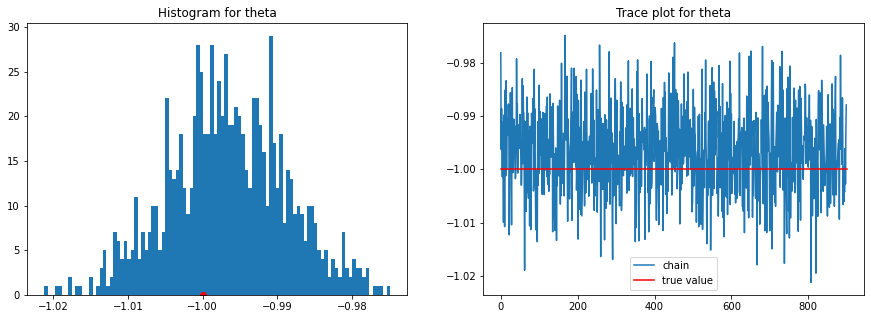

In [238]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(theta_samples, bins=100)
plt.scatter(theta, 0, c="r")
plt.title("Histogram for theta")
plt.subplot(1,2,2)
plt.plot(theta_samples, label="chain")
plt.plot([0, len(theta_samples)], [theta, theta], c="r", label="true value")
plt.title("Trace plot for theta")
plt.legend()
plt.show()

In [239]:
# Analyse w3 
w3_samples = gauss_samples[100:, 3]
w3_est = w3_samples.mean()

print("Estimated w3 ", w3_est)
print("True w3:",w[2])

# Calculate mean square error

mse = mean_squared_error([w3_est], [w[2]])
print("Mean Square Error for w3: ", mse)

Estimated w3  0.6915856337905838
True w3: 0.7
Mean Square Error for w3:  7.080155870616444e-05


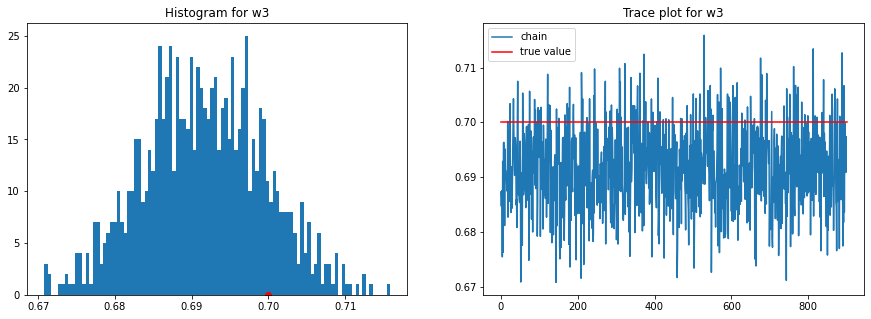

In [240]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(w3_samples, bins=100)
plt.scatter(w[2], 0, c="r")
plt.title("Histogram for w3")
plt.subplot(1,2,2)
plt.plot(w3_samples, label="chain")
plt.plot([0, len(w3_samples)], [w[2], w[2]], c="r", label="true value")
plt.title("Trace plot for w3")
plt.legend()
plt.show()